In [1]:
import numpy as np
import scipy.stats
import matplotlib.pylab as plt
import os, sys
sys.path.insert(0, "../")
import geepee.aep_models as aep
import geepee.ep_models as ep
%matplotlib inline
np.random.seed(42)
import pdb

In [2]:
# We first define several utility functions

def lincos_true(x):
    fx = -0.5*x + 5*np.cos(0.5*x)
    return fx

def lincos(T, process_noise, obs_noise, xprev=None):
    if xprev is None:
        xprev = np.random.randn()
    y = np.zeros([T, ])
    x = np.zeros([T, ])
    xtrue = np.zeros([T, ])
    for t in range(T):
        fx = -0.5*xprev + 5*np.cos(0.5*xprev)
        xtrue[t] = fx
        x[t] = fx + np.sqrt(process_noise)*np.random.randn()
        xprev = x[t]
        y[t] = 0.5*x[t] + np.sqrt(obs_noise)*np.random.randn()

    return xtrue, x, y

    
def plot_latent(model, latent_true, plot_title=''):
    # make prediction on some test inputs
    N_test = 500
    x_test = np.linspace(-10, 8, N_test)
    x_test = np.reshape(x_test, [N_test, 1])
    zu = model.sgp_layer.zu
    mu, vu = model.predict_f(zu)
    mf, vf = model.predict_f(x_test)
    # plot function
    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot(111)
    ax.plot(x_test[:,0], lincos_true(x_test[:,0]), '-', color='k')
    ax.plot(zu, mu, 'ob')
    ax.plot(x_test[:,0], mf[:,0], '-', color='b', label='f, alpha=%.3f' % alpha)
    ax.fill_between(
        x_test[:,0], 
        mf[:,0] + 2*np.sqrt(vf[:,0]), 
        mf[:,0] - 2*np.sqrt(vf[:,0]), 
        alpha=0.2, edgecolor='b', facecolor='b')
    ax.plot(
        latent_true[0:model.N-1], 
        latent_true[1:model.N], 
        'r+', alpha=0.5)
    mx, vx = model.get_posterior_x()
    ax.plot(mx[0:model.N-1], mx[1:model.N], 'og', alpha=0.3)
    ax.set_xlabel(r'$x_{t-1}$')
    ax.set_ylabel(r'$x_{t}$')
    ax.set_xlim([-10, 8])
    ax.legend(loc='lower center')
    plt.title(plot_title)
    
#     # plot function
#     fig = plt.figure(figsize=(16,10))
#     ax = fig.add_subplot(111)
#     mx, vx = model.get_posterior_x()
#     ax.plot(np.arange(model.N), mx, '-g', alpha=0.5)
#     ax.fill_between(
#         np.arange(model.N), 
#         mx[:,0] + 2*np.sqrt(vx[:,0]), 
#         mx[:,0] - 2*np.sqrt(vx[:,0]), 
#         alpha=0.3, edgecolor='g', facecolor='g')
#     ax.plot(np.arange(model.N), latent_true, 'r+', alpha=0.5)
#     ax.set_xlabel(r'$t$')
#     ax.set_ylabel(r'$x_{t}$')
#     ax.set_xlim([0, model.N])
#     ax.legend(loc='lower center')
#     plt.title(plot_title)
    
#     se = (latent_true - mx[:, 0])**2
#     mse = np.mean(se)
#     se_std = np.std(se)/np.sqrt(se.shape[0])
    
#     ll = -0.5 * (latent_true - mx[:, 0])**2/vx[:, 0] -0.5*np.log(2*np.pi*vx[:, 0])
#     mll = np.mean(ll)
#     ll_std = np.std(ll)/np.sqrt(ll.shape[0])
#     print 'se %.3f +/- %.3f' % (mse, se_std)
#     print 'll %.3f +/- %.3f' % (mll, ll_std)
    

In [3]:
# generate a dataset from the lincos function above
T = 200
process_noise = 0.3
obs_noise = 0.2
(xtrue, x, y) = lincos(T, process_noise, obs_noise)
y_train = np.reshape(y, [y.shape[0], 1])

# init hypers
Dlatent = 1
Dobs = 1
M = 30
C = 0.5*np.ones((1, 1))
R = np.ones(1)*np.log(obs_noise)/2
lls = np.reshape(np.log(2), [Dlatent, ])
lsf = np.reshape(np.log(2), [1, ])
zu = np.linspace(-8, 6, M)
zu = np.reshape(zu, [M, 1])
lsn = np.log(0.01)/2
params = {'ls': lls, 'sf': lsf, 'sn': lsn, 'R': R, 'C': C, 'zu': zu}

alpha = 0.001
epoch 0/100
epoch 50/100
alpha = 0.050
epoch 0/100
epoch 50/100
alpha = 0.200
epoch 0/100
epoch 50/100
alpha = 0.500
epoch 0/100

../geepee/aep_models.py:484: RuntimeWarning: invalid value encountered in log
  Rd[diag_ind] = np.log(Rd[diag_ind])
../geepee/ep_models.py:992: RuntimeWarning: invalid value encountered in log
  const_term = -0.5 * np.log(2*np.pi*v_sum)



epoch 50/100
alpha = 1.000
epoch 0/100
epoch 50/100


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in sqrt


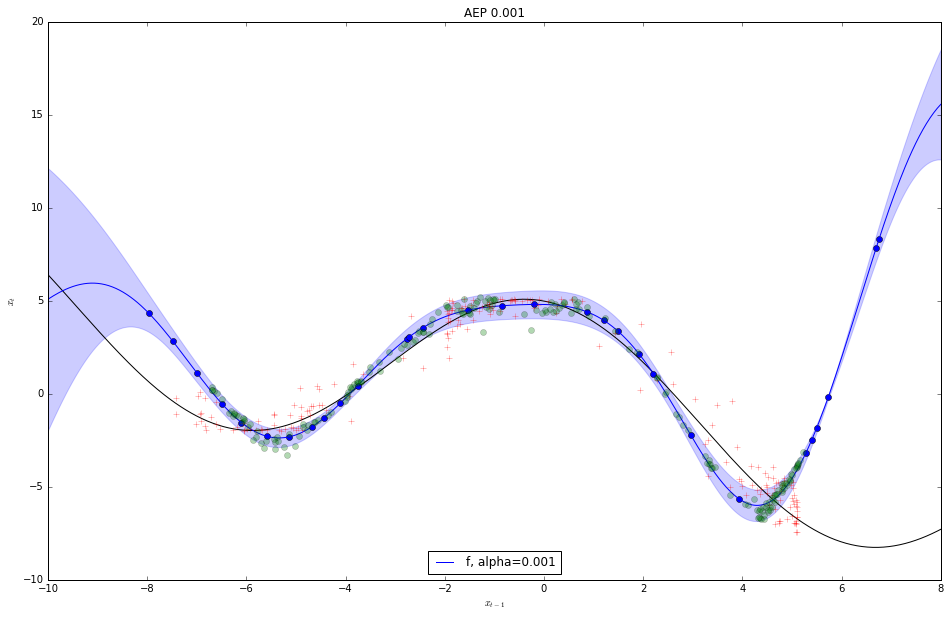

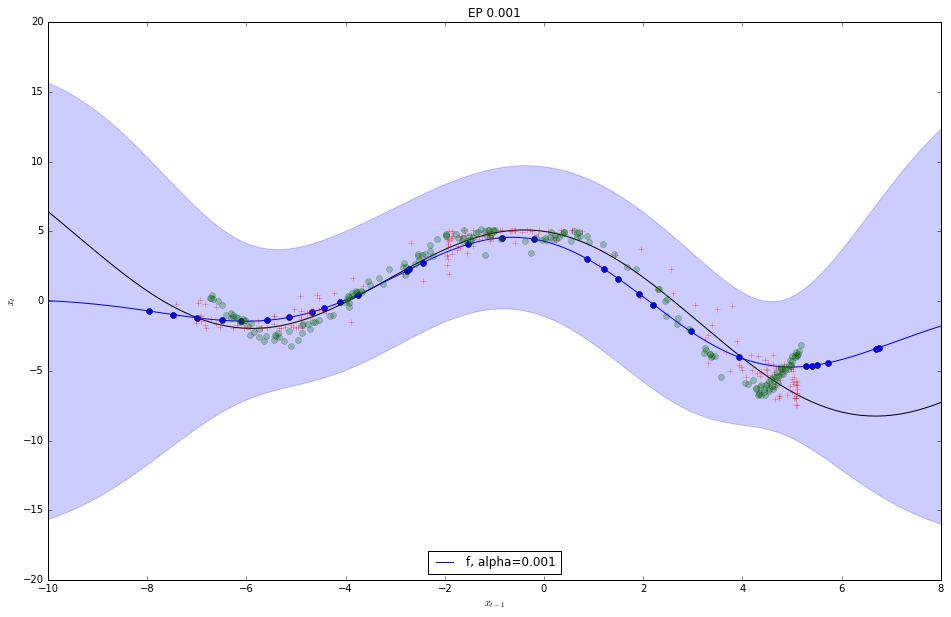

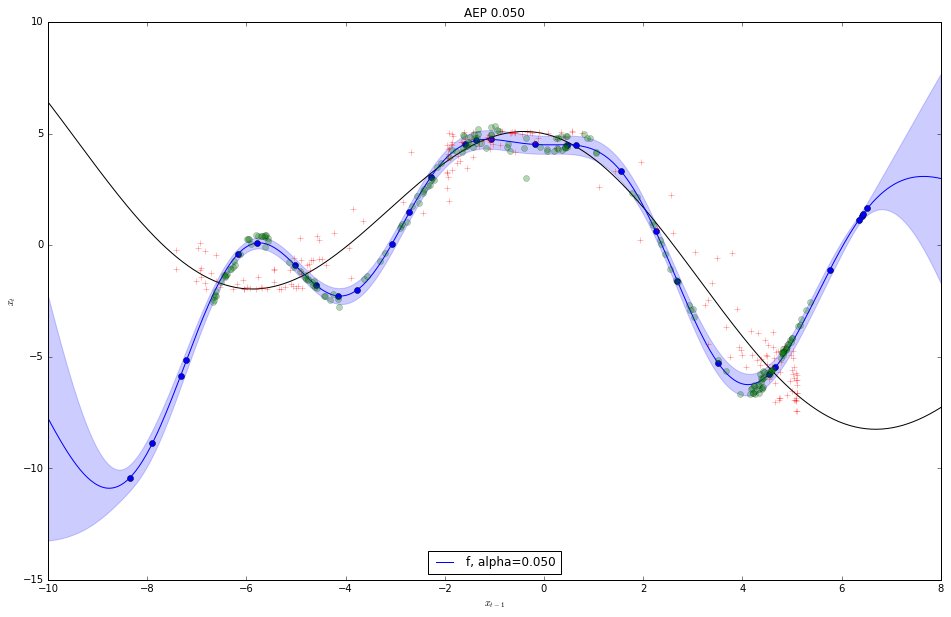

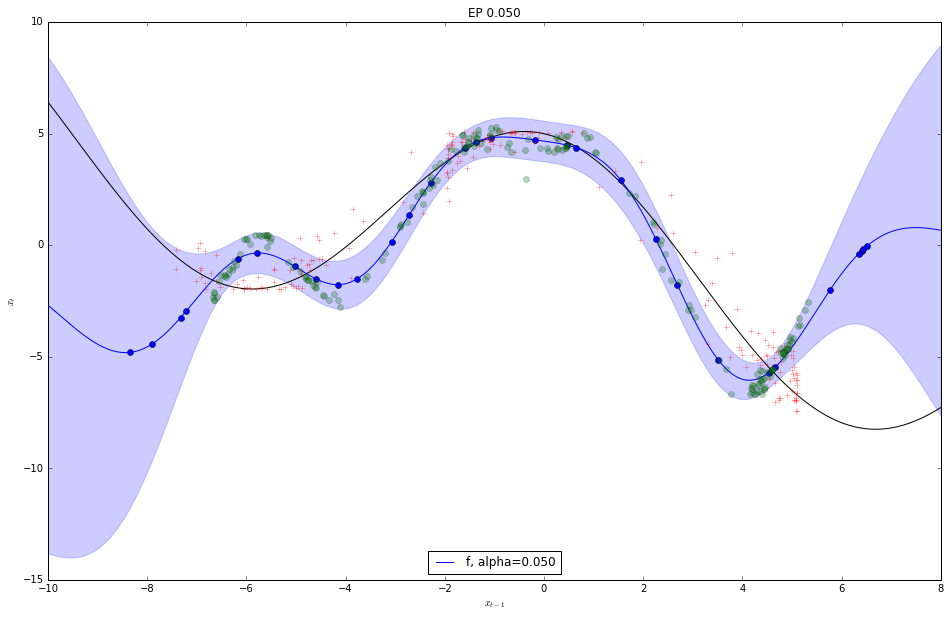

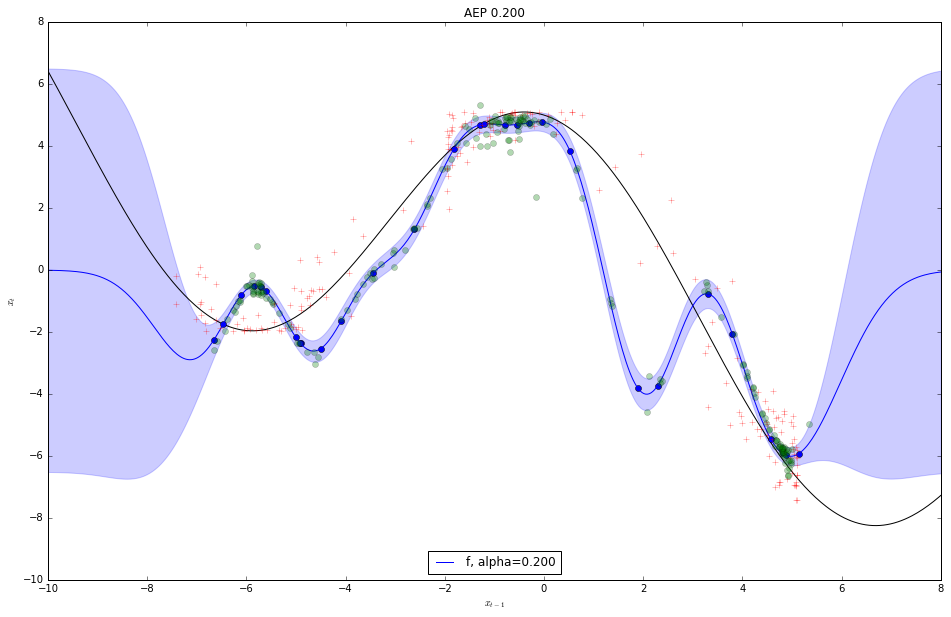

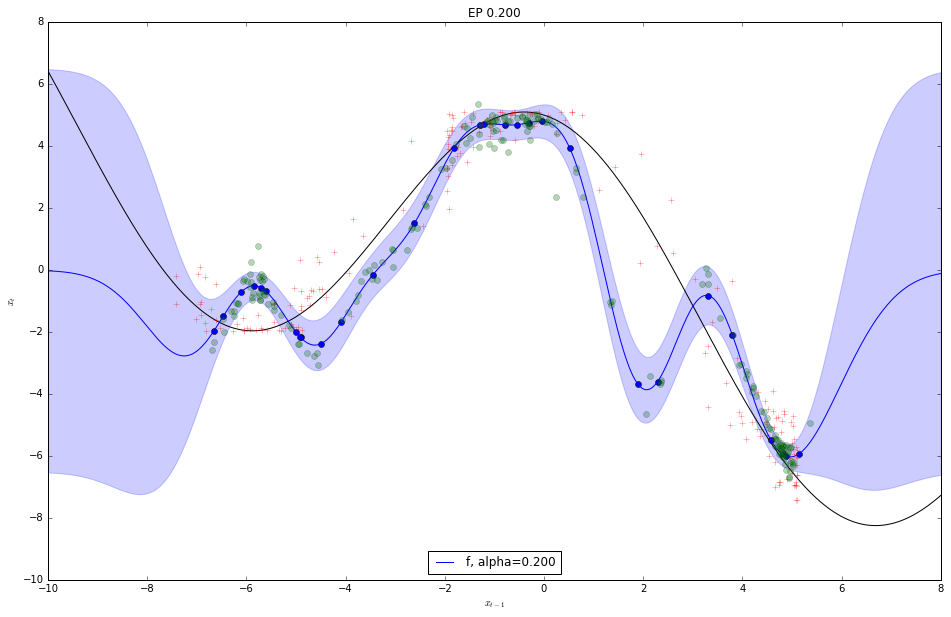

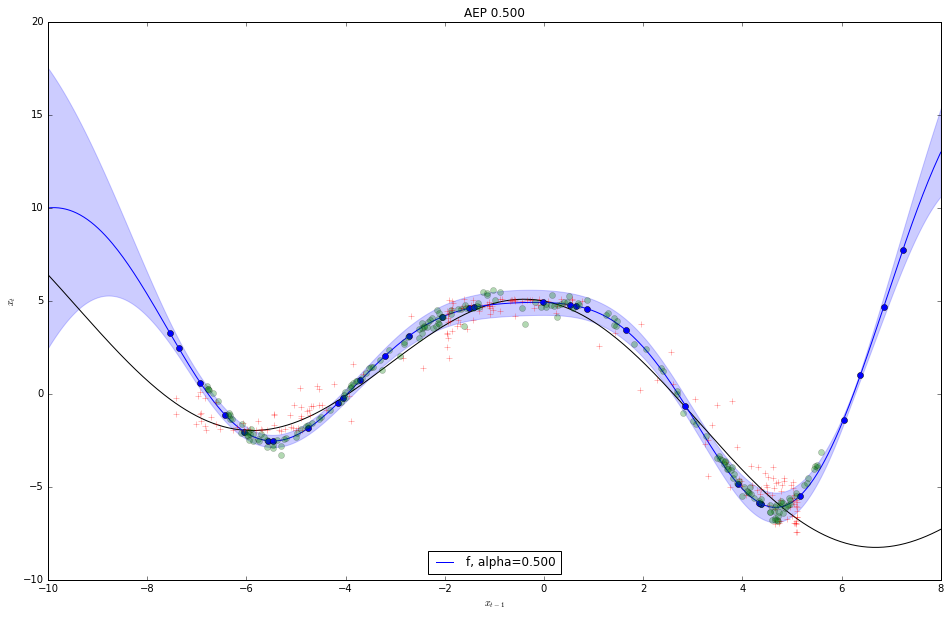

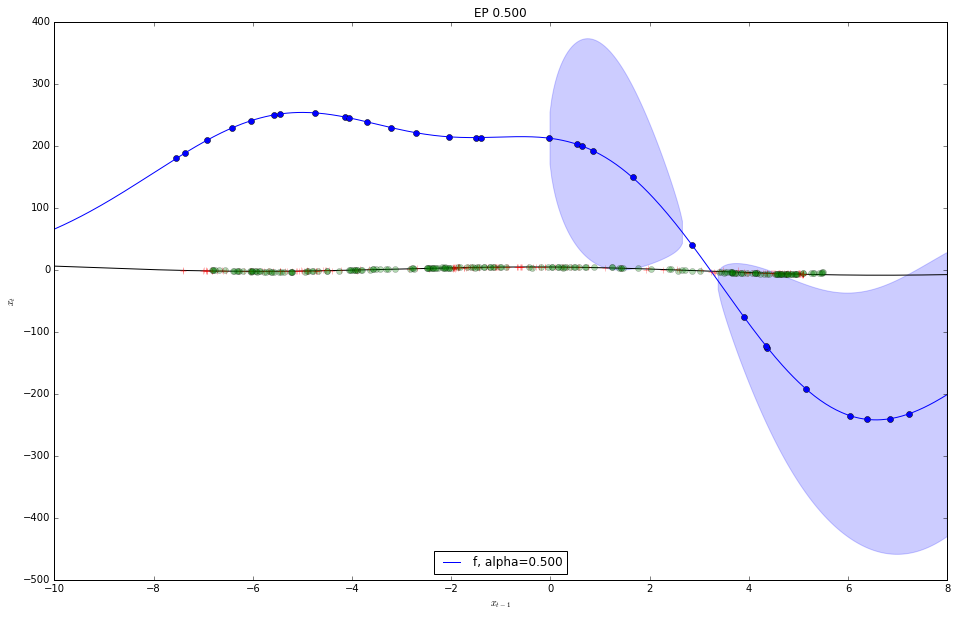

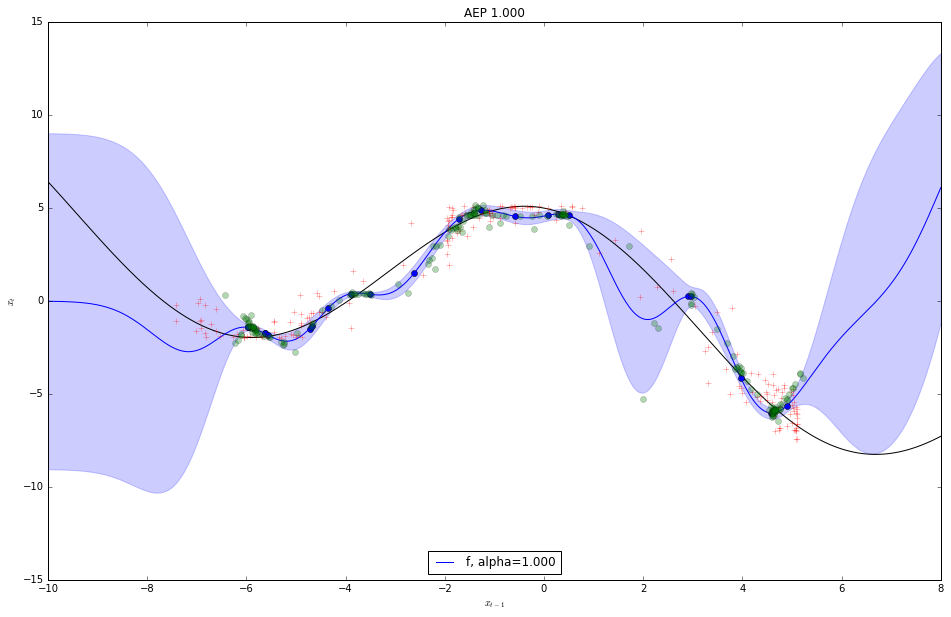

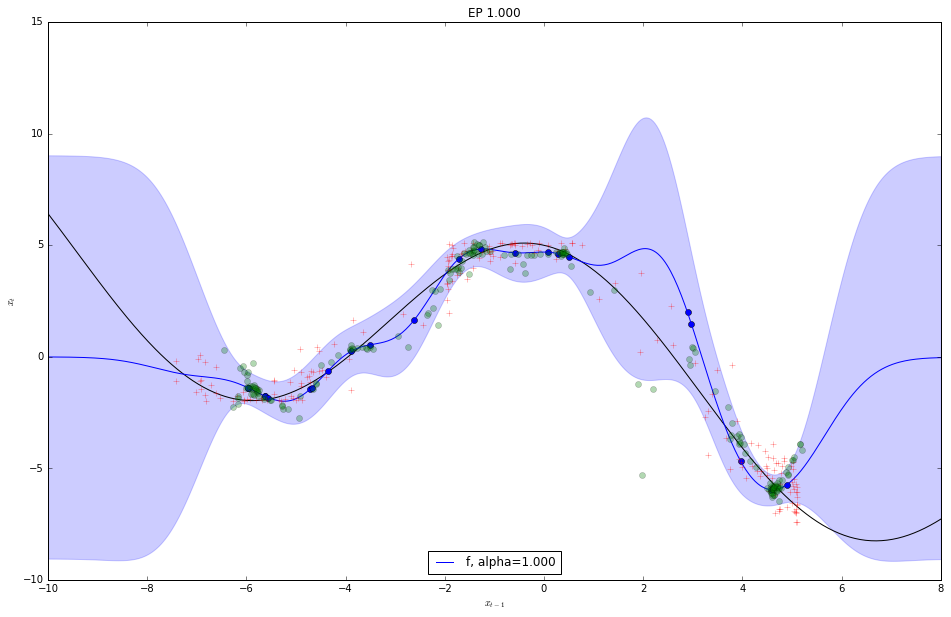

In [4]:
alphas = [0.001, 0.05, 0.2, 0.5, 1.0]
for alpha in alphas:
    print 'alpha = %.3f' % alpha
    # create AEP model
    model_aep = aep.SGPSSM(y_train, Dlatent, M, 
        lik='Gaussian', prior_mean=0, prior_var=1000)
    hypers = model_aep.init_hypers(y_train)
    for key in params.keys():
        hypers[key] = params[key]
    model_aep.update_hypers(hypers, alpha)
    # optimise
    model_aep.set_fixed_params(['C', 'R'])
    model_aep.optimise(method='L-BFGS-B', alpha=alpha, maxiter=20000, reinit_hypers=False)
    opt_hypers = model_aep.get_hypers()
    # plot(model_aep, 'AEP %.3f'%alpha)
    plot_latent(model_aep, xtrue, 'AEP %.3f'%alpha)

    # create EP model
    model_ep = ep.SGPSSM(y_train, Dlatent, M, 
        lik='Gaussian', prior_mean=0, prior_var=1000)
    # init EP model using the AEP solution
    model_ep.update_hypers(opt_hypers)
    aep_sgp_layer = model_aep.sgp_layer
    Nm1 = aep_sgp_layer.N
    model_ep.sgp_layer.theta_1 = 1.0/Nm1 * np.tile(
        aep_sgp_layer.theta_2[np.newaxis, :, :], [Nm1, 1, 1])
    model_ep.sgp_layer.theta_2 = 1.0/Nm1 * np.tile(
        aep_sgp_layer.theta_1[np.newaxis, :, :], [Nm1, 1, 1])
    model_ep.x_prev_1 = np.copy(model_aep.x_factor_1)
    model_ep.x_prev_2 = np.copy(model_aep.x_factor_2)
    model_ep.x_next_1 = np.copy(model_aep.x_factor_1)
    model_ep.x_next_2 = np.copy(model_aep.x_factor_2)
    model_ep.x_up_1 = np.copy(model_aep.x_factor_1)
    model_ep.x_up_2 = np.copy(model_aep.x_factor_2)
    model_ep.x_prev_1[0, :] = 0
    model_ep.x_prev_2[0, :] = 0
    model_ep.x_next_1[-1, :] = 0
    model_ep.x_next_2[-1, :] = 0
    # run EP
    if alpha == 1.0 or alpha == 0.5:
        decay = 0.999
    else:
        decay = 0.99
    model_ep.inference(no_epochs=100, alpha=alpha, parallel=True, decay=decay)
    
    # plot(model_ep, 'EP %.3f'%alpha)
    plot_latent(model_ep, xtrue, 'EP %.3f'%alpha)